In [1]:
import numpy as np
import tensorflow as tf
from angorapy.analysis.investigation import Investigator
from angorapy.agent.ppo_agent import PPOAgent
from angorapy.common.policies import MultiCategoricalPolicyDistribution, BetaPolicyDistribution
from angorapy.common.transformers import RewardNormalizationTransformer, StateNormalizationTransformer
from angorapy.common.wrappers import make_env

from angorapy.models import get_model_builder

2023-01-27 12:18:01.716498: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 12:18:01.716519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Invalid MIT-MAGIC-COOKIE-1 key

A MuJoCo path exists. MuJoCo is being loaded...


For most environments, PPO needs to normalize states and rewards; to add this functionality we wrap the environment with transformers fulfilling this task. You can also add your own custom transformers this way.

In [2]:
wrappers = [StateNormalizationTransformer, RewardNormalizationTransformer]
env = make_env("LunarLanderContinuous-v2", reward_config=None, transformers=wrappers)

Next, we need to create the policy distribution we would like to model to map to. We will use a beta distribution. Since the distribution will depend on the action space of the environment, we need to provide the distribution with the environment object.

In [3]:
distribution = BetaPolicyDistribution(env)

Lastly, we need a model. To that end, we create a *model builder*. AngoraPy needs to be able to constantly build new versions of the model. Thus, it requires a model building function instead of a model instance. This function must return a tuple of (policy, value, joint) network. The former are the network selecting the action (policy network) and valuating the state (value network. The latter is their combination. The separation of the three serves computational efficiency.

For built in architectures, we can use the *get_model_builder()* function. Lets also check the models this model builder creates.

2023-01-27 12:18:04.009147: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-27 12:18:04.009934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-27 12:18:04.044066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 462.00GiB/s
2023-01-27 12:18:04.044284: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 12:18:04.050207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-27 12:18:04.050293: I tensorflow/stream_execut

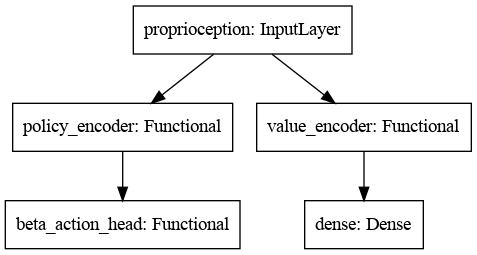

In [4]:
build_models = get_model_builder(model="simple", model_type="ffn", shared=False)
policy, value, joint = build_models(env, distribution)

tf.keras.utils.plot_model(joint)

We can see that the model created three network references. Importantly, it is references, as any change to the value or policy network will also change the joint network and vice versa. In the model plot, we can also see how policy and value network are separated. They only share their input, but not their weights.

With model, environment and distribution set up, we can now assemble an agent.

In [5]:
agent = PPOAgent(build_models, env, horizon=1024, workers=12, distribution=distribution)

# let's check the agents ID, so we can find its saved states after training
print(f"My Agent's ID: {agent.agent_id}")

Detected 0 GPU devices.
Using [StateNormalizationTransformer, RewardNormalizationTransformer] for preprocessing.
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]
My Agent's ID: 1674818284853356


We will now train the agent for 10 cycle and afterwards save the final state. AngoraPy will additionally always save the agents best version.

In [6]:
# ... and then train that agent for n cycles
agent.drill(n=10, epochs=3, batch_size=64)

# after training, we can save the agent for analysis or the like
agent.save_agent_state()



Drill started using 1 processes for 12 workers of which 1 are optimizers. Worker distribution: [12].
IDs over Workers: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
IDs over Optimizers: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
Gathering cycle 0...

2023-01-27 12:18:04.498136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-27 12:18:04.498515: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Before Training: r:  -243.45; len:    98.03; n: 118; loss: [  pi  |  v     |  ent ]; eps:     0; lr: 1.00e-03; upd:      0; f:    0.000k; y.exp: 0.00000; times:  ; took s [unknown time left]; mem: 0.53/33|0.0/0.0;
Cycle     1/10: r:  -195.66; len:   102.96; n: 113; loss: [ -0.05|    0.34| -0.17]; eps:   118; lr: 1.00e-03; upd:    576; f:   12.288k; times: [39.0|0.0|10.9] [78|0|22]; took 50.51s [7.6mins left]; mem: 0.59/33|0.0/0.0;
Cycle     2/10: r:  -137.41; len:   101.17; n: 115; loss: [ -0.02|    0.25| -0.18]; eps:   231; lr: 1.00e-03; upd:   1152; f:   24.576k; times: [39.4|0.0|10.2] [79|0|21]; took 45.79s [6.4mins left]; mem: 0.6/33|0.0/0.0;
Cycle     3/10: r:  -112.35; len:   108.84; n:  99; loss: [ -0.08|    0.09| -0.20]; eps:   346; lr: 1.00e-03; upd:   1728; f:   36.864k; times: [35.4|0.0|10.0] [78|0|22]; took 47.19s [5.6mins left]; mem: 0.61/33|0.0/0.0;
Cycle     4/10: r:   -84.23; len:   104.76; n: 107; loss: [ -0.11|    0.08| -0.22]; eps:   445; lr: 1.00e-03; upd:   2304; f

After training is done, we can evaluate the agent. For this purpose we tell the agent to *act confidently*. Because policies in AngoraPy are stochastic, actions are usually sampled from the policy distribution. At evaluation time, we would however prefer the agent to stop exploring and instead choose the action it is most confident about. Thus, when told to act confidently, the agent will not sample but instead choose the most likely action under the predicted distribution.

In [7]:
evaluation_results = agent.evaluate(10, act_confidently=True)[0]
print(np.mean(evaluation_results.episode_rewards))

-137.64708870118506


In [8]:
inv = Investigator.from_agent(agent)
inv.render_episode(agent.env, act_confidently=True)

ValueError: too many values to unpack (expected 4)